(pre-processing:dimensionality-reduction)=
# Dimensionality Reduction

As previously mentioned, scRNA-seq is a high-throughput sequencing technology that produces datasets with high dimensions in the number of cells and genes.
This immediately points to the fact that scRNA-seq data suffers from the 'curse of dimensionality'. 

```{admonition} Curse of dimensionality
The Curse of dimensionality was first brought up by R. Bellman {cite}`bellman1957dynamic` and describes the problem that, in theory, high-dimensional data contains more information, but in practice this is not the case.
Higher-dimensional data often contains more noise and redundancy, and therefore, adding more information does not provide benefits for downstream analysis steps. 
```

Not all genes are informative and are important for the task of cell type clustering based on their expression profiles.
We already aimed to reduce the dimensionality of the data with feature selection, as a next step, one can further reduce the dimensions of single-cell RNA-seq data with dimensionality reduction algorithms. 
These algorithms are an important step during preprocessing to reduce the data complexity and for visualization.
Several dimensionality reduction techniques have been developed and used for single-cell data analysis.

:::{figure-md} Dimensionality reduction

<img src="../_static/images/preprocessing_visualization/dimensionality_reduction.jpeg" alt="Dimensionality reduction" class="bg-primary mb-1" width="800px">

Dimensionality reduction embeds the high-dimensional data into a lower-dimensional space.
The low-dimensional representation still captures the underlying structure of the data while having as few dimensions as possible.
Here we visualize a three-dimensional object projected into two dimensions. 

:::

Xing et al. compared in an independent comparison the stability, accuracy, and computing cost of 10 different dimensionality reduction methods {cite}`Xiang2021`.
They propose to use t-distributed stochastic neighbor embedding (t-SNE) as it yielded the best overall performance.
Uniform manifold approximation and projection (UMAP) showed the highest stability and separated the original cell populations best.
An additional dimensionality reduction worth mentioning in this context is principal component analysis (PCA), which is still widely used.

Generally, t-SNE and UMAP are very robust and mostly equivalent if specific choices for the initialization are selected {cite}`Kobak2019`.

All aforementioned methods are implemented in scanpy.


In [1]:
import lamindb as ln
import scanpy as sc

assert ln.setup.settings.instance.slug == "theislab/sc-best-practices"

ln.track()

→ connected lamindb: theislab/sc-best-practices
→ loaded Transform('liGMVGre4G5H0000'), re-started Run('ZFh04bqi...') at 2025-04-18 13:51:46 UTC
→ notebook imports: scanpy==1.11.1


In [2]:
af = ln.Artifact.get(
    key="preprocessing_visualization/s4d8_feature_selection.h5ad", is_latest=True
)
adata = af.load()

We will use a normalized representation of the dataset for dimensionality reduction and visualization, specifically the shifted logarithm. 

In [3]:
adata.X = adata.layers["log1p_norm"]

We start with:

(preprocessing-visualization-dimensionality-reduction-key-takeaway-1)=
## PCA

In our dataset, each cell is a vector of a `n_var`-dimensional vector space spanned by some orthonormal basis.
As scRNA-seq suffers from the 'curse of dimensionality', we know that not all features are important to understand the underlying dynamics of the dataset and that there is an inherent redundancy{cite}`grun2014validation`.
PCA creates a new set of uncorrelated variables, so-called principal components (PCs), via an orthogonal transformation of the original dataset.
The PCs are linear combinations of features in the original dataset and are ranked in decreasing order of variance to define the transformation.
In the ranking, the first PC typically captures the greatest amount of variance.
PCs with the lowest variance are discarded to effectively reduce the dimensionality of the data without losing information.

PCA offers the advantage that it is highly interpretable and computationally efficient.
However, as scRNA-seq datasets are rather sparse due to dropout events and therefore highly non-linear, visualization with the linear dimensionality reduction technique PCA is not very appropriate.
PCA is typically used to select the top 10-50 PCs, which are used for downstream analysis tasks.

In [4]:
# setting highly variable as highly deviant to use scanpy 'use_highly_variable' argument in sc.pp.pca
adata.var["highly_variable"] = adata.var["highly_deviant"]
sc.pp.pca(adata, svd_solver="arpack", mask_var="highly_variable")

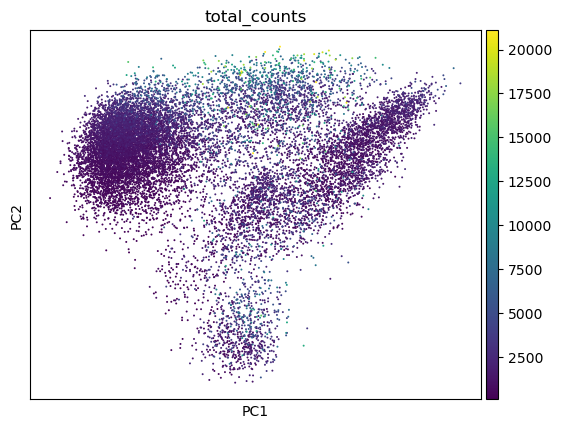

In [5]:
sc.pl.pca_scatter(adata, color="total_counts")

## t-SNE

t-SNE is a graph based, non-linear dimensionality reduction technique which projects the high dimensional data onto 2D or 3D components.
The method defines a Gaussian probability distribution based on the high-dimensional Euclidean distances between data points.
Subsequently, a Student t-distribution is used to recreate the probability distribution in a low dimensional space where the embeddings are optimized using gradient descent.

In [6]:
sc.tl.tsne(adata, use_rep="X_pca")

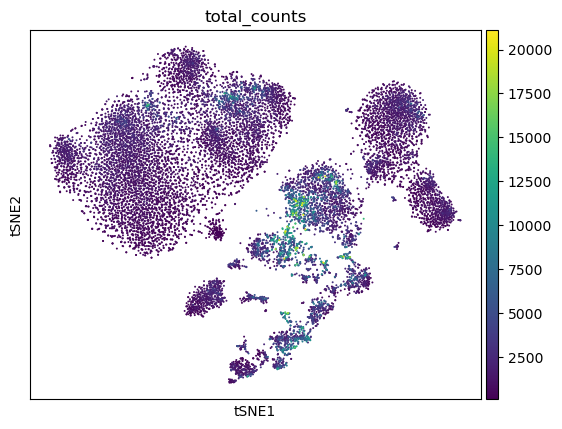

In [7]:
sc.pl.tsne(adata, color="total_counts")

(preprocessing-visualization-dimensionality-reduction-key-takeaway-2)=
## UMAP

UMAP is a graph-based, non-linear dimensionality reduction technique and is principally similar to t-SNE.
It constructs a high-dimensional graph representation of the dataset and optimizes the low-dimensional graph representation to be as structurally similar as possible to the original graph.


We first calculate PCA and subsequently create a neighborhood graph based on our data.

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

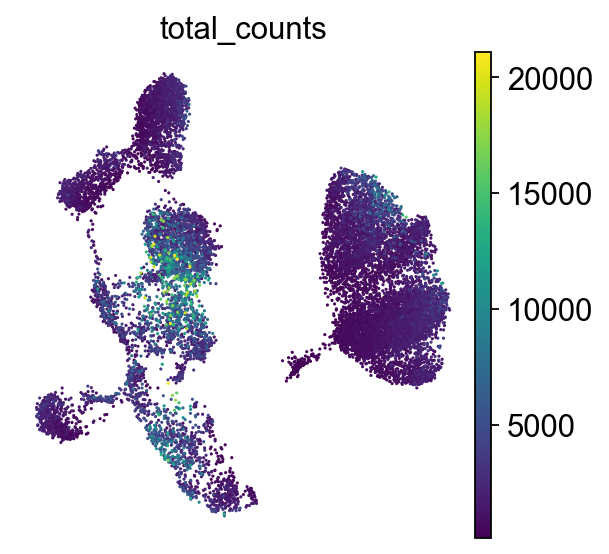

In [9]:
sc.pl.umap(adata, color="total_counts")

## Inspecting quality control metrics 

We can now also inspect the quality control metrics we calculated previously in our PCA, TSNE or UMAP plot and potentially identify low-quality cells.

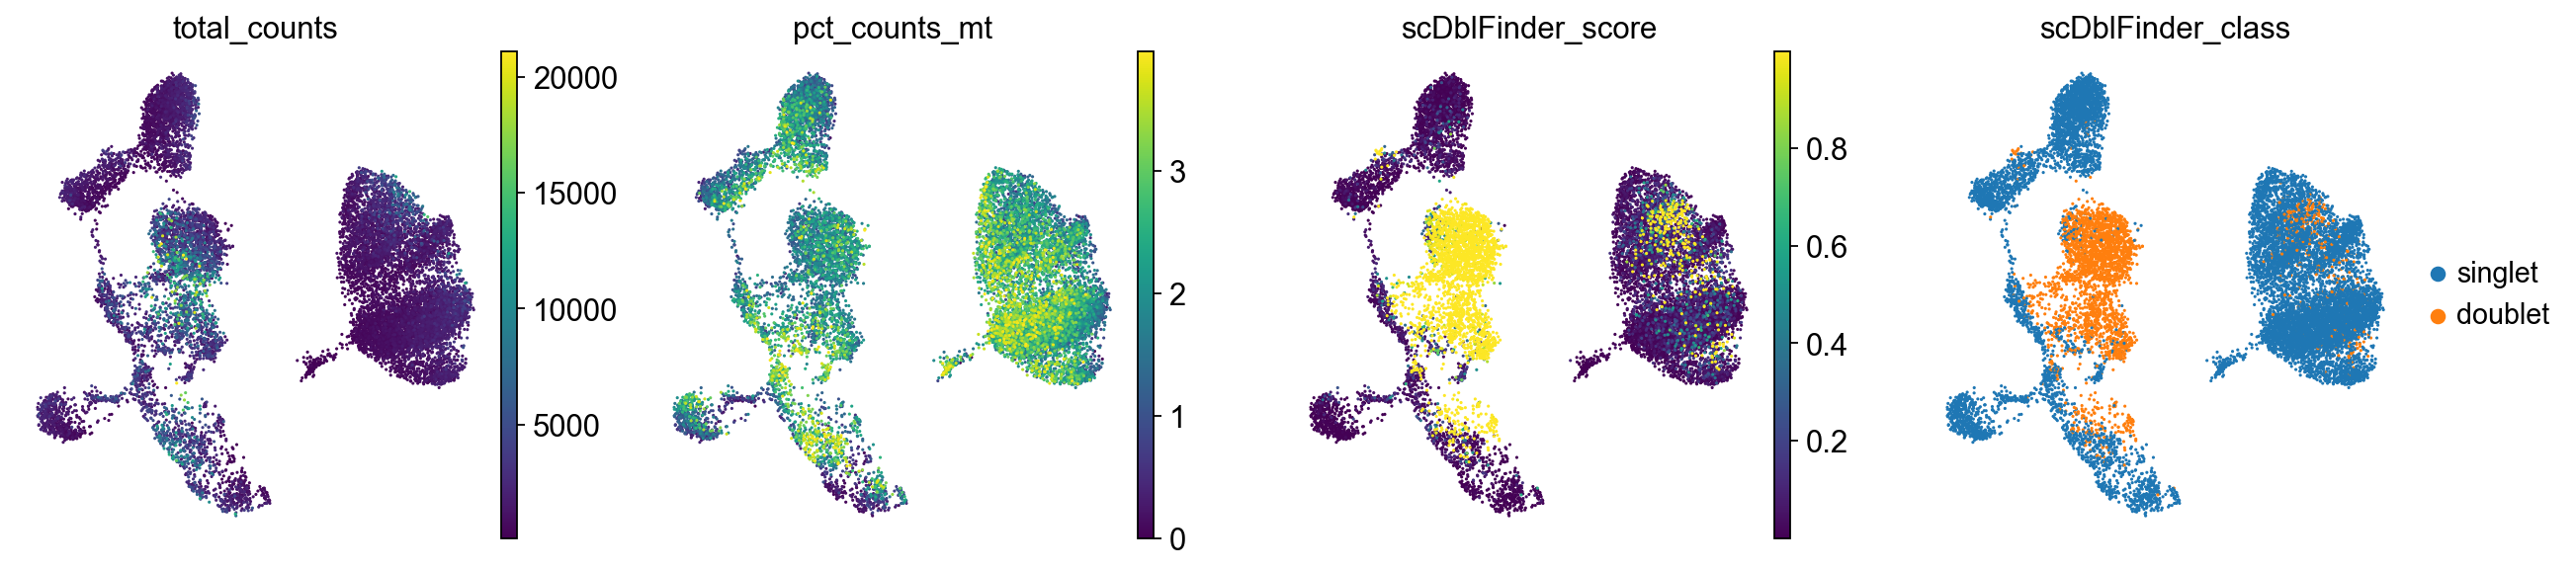

In [ ]:
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt", "scDblFinder_score", "scDblFinder_class"],
)

As we can observe, cells with a high doublet score are projected to the same region in the UMAP.
We will keep them in the dataset for now but might re-visit our quality control strategy later.
You don't have to run the cell below.

In [ ]:
adata.write("s4d8_dimensionality_reduction.h5ad")
af = ln.Artifact(
    "s4d8_dimensionality_reduction.h5ad",
    key="preprocessing_visualization/s4d8_dimensionality_reduction.h5ad",
    description="anndata after dimensionality reduction",
).save()
af

## References

```{bibliography}
:filter: docname in docnames
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Anna Schaar

### Reviewers

* Lukas Heumos
